Load Packages

In [2]:
import numpy as np
from pathlib import Path
import pandas as pd
import torch
import os
import pickle
import glob
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.rcParams['font.family'] = 'Times New Roman'

## Process the THINGS fMRI RDMs

In [25]:
# Load all the files from the fmri_path directory that contain the word 'va-1', or 'va-2', or 'va-3', 'rLOC' or 'lLOC'
fmri_path = Path('/home/wallacelab/teba/multimodal_brain_inspired/THINGS-fMRI_Complete/all_rdm')
fmri_files = list(fmri_path.glob("*va-1_*")) + list(fmri_path.glob("*va-2_*")) + list(fmri_path.glob("*va-3_*")) + list(fmri_path.glob("*lLOC*")) + list(fmri_path.glob("*rLOC*"))

# create a dictionary to store the fMRI RDMs
fmri_rdms = {}

for file in fmri_files:
    # extract the subject number from the file name
    subject_number = file.stem.split('_')[0].split('-')[1]
    print(subject_number)
    # extract the roi from the file name
    # This pattern is looking for the ROI name as the second element after splitting the filename (without extension) by underscores.
    if 'va' in file.stem:
        roi = file.stem.split('_')[2]
    else:
        roi = file.stem.split('_')[1]
    print(roi)
    fmri_rdm = np.load(file)
    print(fmri_rdm.shape)
    # store the fMRI RDM in the dictionary
    fmri_rdms[subject_number + '_' + roi] = fmri_rdm

# # print the first 5x5 of every fMRI RDM in the dictionary
for key in fmri_rdms:
    print(key)
    print(fmri_rdms[key][:5, :5])

02
va-1
(720, 720)
03
va-1
(720, 720)
01
va-1
(720, 720)
01
va-2
(720, 720)
02
va-2
(720, 720)
03
va-2
(720, 720)
01
va-3
(720, 720)
03
va-3
(720, 720)
02
va-3
(720, 720)
03
lLOC
(720, 720)
01
lLOC
(720, 720)
02
lLOC
(720, 720)
02
rLOC
(720, 720)
03
rLOC
(720, 720)
01
rLOC
(720, 720)
02_va-1
[[0.         0.5        0.45833333 0.58333333 0.625     ]
 [0.5        0.         0.625      0.70833333 0.875     ]
 [0.45833333 0.625      0.         0.58333333 0.375     ]
 [0.58333333 0.70833333 0.58333333 0.         0.54166667]
 [0.625      0.875      0.375      0.54166667 0.        ]]
03_va-1
[[0.         0.625      0.75       0.75       0.41666667]
 [0.625      0.         0.66666667 0.58333333 0.41666667]
 [0.75       0.66666667 0.         0.375      0.58333333]
 [0.75       0.58333333 0.375      0.         0.58333333]
 [0.41666667 0.41666667 0.58333333 0.58333333 0.        ]]
01_va-1
[[0.         0.75       0.41666667 0.66666667 0.54166667]
 [0.75       0.         0.70833333 0.75       0.75 

Get the variable names for our five ROIs.

In [26]:
fmri_rdms_rois = list(set([key.split('_')[1] for key in fmri_rdms.keys()]))

print(fmri_rdms_rois)

for roi in fmri_rdms_rois:
    # Create a dictionary of RDMs for the current ROI, using the ROI name in the variable name
    roi_rdms_varname = f"{roi}_rdms"
    locals()[roi_rdms_varname] = {k: v for k, v in fmri_rdms.items() if roi in k}

    print(roi_rdms_varname)

['va-2', 'lLOC', 'va-1', 'va-3', 'rLOC']
va-2_rdms
lLOC_rdms
va-1_rdms
va-3_rdms
rLOC_rdms


In [27]:
# Loading the concept index for the fMRI RDM

concept_index = np.load('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/sub-01_LOC_concept_index.npy')

print(concept_index)

['acorn' 'airbag' 'aircraft_carrier' 'airplane' 'alligator' 'aloe' 'altar'
 'aluminum_foil' 'anchor' 'anklet' 'ant' 'anteater' 'antelope' 'antenna'
 'anvil' 'apple' 'applesauce' 'artichoke' 'ashtray' 'asparagus' 'avocado'
 'axe' 'baby' 'backpack' 'bag' 'bagel' 'ball' 'balloon' 'bamboo' 'banana'
 'banana_split' 'bandage' 'banner' 'barnacle' 'barrel' 'basket' 'bassinet'
 'battery' 'beachball' 'beaker' 'bean' 'bear' 'beaver' 'bed' 'bee' 'beer'
 'beet' 'beetle' 'bell' 'bench' 'bib' 'bike' 'binoculars' 'bird'
 'birdcage' 'birdhouse' 'bison' 'blackberry' 'blanket' 'blazer' 'blender'
 'blimp' 'blind' 'blowtorch' 'blueberry' 'boa' 'boar' 'boat' 'bobsled'
 'bolt' 'book' 'boot' 'bottle' 'bow2' 'bowl' 'boxer_shorts'
 'boxing_gloves' 'boy' 'brace' 'bracelet2' 'bracket' 'bread' 'breadbox'
 'breadstick' 'broccoli' 'broom' 'brownie' 'brush' 'bubble' 'bucket'
 'buggy' 'bulldozer' 'bullet' 'bumper' 'bungee' 'bunkbed' 'burner'
 'burrito' 'bus' 'butterfly' 'cabbage' 'cactus' 'cage' 'cake' 'calculator'
 '

Calculate the average concept RDM for each ROI across subjects.

In [28]:
# Create averaged upper triangle vectors for all ROIs
# First, identify all unique ROIs from the fmri_rdms dictionary
rois = set()
for key in fmri_rdms.keys():
    roi = key.split('_')[1]  # Extract ROI from key like '01_lLOC' -> 'lLOC'
    rois.add(roi)

print("Available ROIs:", sorted(rois))

# Create a dictionary to store averaged upper triangle vectors for each ROI
roi_average_upper_triangles = {}

# Get upper triangular indices (same for all RDMs since they're all 720x720)
upper_tri_indices = np.triu_indices_from(fmri_rdms[list(fmri_rdms.keys())[0]], k=1)

for roi in sorted(rois):
    print(f"\nProcessing ROI: {roi}")
    
    # Filter RDMs for this specific ROI
    roi_rdms = {k: v for k, v in fmri_rdms.items() if roi in k}
    print(f"Found {len(roi_rdms)} RDMs for {roi}")
    
    # Extract upper triangular elements for each RDM
    roi_rdms_upper = {}
    for key in roi_rdms:
        roi_rdms_upper[key] = roi_rdms[key][upper_tri_indices]
    
    # Stack the vectors into a single array
    roi_rdms_upper_array = np.stack(list(roi_rdms_upper.values()))
    print(f"Stacked array shape: {roi_rdms_upper_array.shape}")
    
    # Calculate the average across subjects
    # axis=0 means we are taking the mean down the rows (i.e., column-wise), so for each position in the upper triangle vector, we average across all subjects' RDMs
    roi_average_upper_triangle = np.mean(roi_rdms_upper_array, axis=0)
    print(f"Average vector shape: {roi_average_upper_triangle.shape}")
    
    # Store in the dictionary
    roi_average_upper_triangles[roi] = roi_average_upper_triangle
    
    # Print first 5 values as a sanity check
    print(f"First 5 values for {roi}: {roi_average_upper_triangle[:5]}")

print(f"\nCreated averaged upper triangle vectors for {len(roi_average_upper_triangles)} ROIs:")
for roi in roi_average_upper_triangles:
    print(f"  {roi}: shape {roi_average_upper_triangles[roi].shape}")

Available ROIs: ['lLOC', 'rLOC', 'va-1', 'va-2', 'va-3']

Processing ROI: lLOC
Found 3 RDMs for lLOC
Stacked array shape: (3, 258840)
Average vector shape: (258840,)
First 5 values for lLOC: [0.63888889 0.55555556 0.625      0.61111111 0.54166667]

Processing ROI: rLOC
Found 3 RDMs for rLOC
Stacked array shape: (3, 258840)
Average vector shape: (258840,)
First 5 values for rLOC: [0.68055556 0.51388889 0.69444444 0.56944444 0.54166667]

Processing ROI: va-1
Found 3 RDMs for va-1
Stacked array shape: (3, 258840)
Average vector shape: (258840,)
First 5 values for va-1: [0.625      0.54166667 0.66666667 0.52777778 0.48611111]

Processing ROI: va-2
Found 3 RDMs for va-2
Stacked array shape: (3, 258840)
Average vector shape: (258840,)
First 5 values for va-2: [0.61111111 0.54166667 0.625      0.43055556 0.43055556]

Processing ROI: va-3
Found 3 RDMs for va-3
Stacked array shape: (3, 258840)
Average vector shape: (258840,)
First 5 values for va-3: [0.59722222 0.52777778 0.66666667 0.5        

Average the fMRI activity between left and right LOC.

In [29]:
roi_average_upper_triangles['LOC'] = np.mean(
    np.stack([roi_average_upper_triangles['lLOC'], roi_average_upper_triangles['rLOC']]), axis=0
)

print(roi_average_upper_triangles['LOC'].shape)

print(roi_average_upper_triangles['rLOC'].shape)

print(roi_average_upper_triangles.keys())

# remove the lLOC and rLOC keys, if they exist
removed_lLOC = roi_average_upper_triangles.pop('lLOC', None)
removed_rLOC = roi_average_upper_triangles.pop('rLOC', None)
print(f"Removed lLOC: {removed_lLOC is not None}, Removed rLOC: {removed_rLOC is not None}")

print(roi_average_upper_triangles.keys())

(258840,)
(258840,)
dict_keys(['lLOC', 'rLOC', 'va-1', 'va-2', 'va-3', 'LOC'])
Removed lLOC: True, Removed rLOC: True
dict_keys(['va-1', 'va-2', 'va-3', 'LOC'])


## Process CLIP-HBA Embedding Data

### Baseline Seed 1

Load the CLIP-HBA-behavior last-layer embeddings from the 720 images that make up the 720 concepts (1 images per concept). 

In [39]:
things_baseline_seed1_embeddings_path = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed1/inference_results/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts')

# get all the files in the nod_baseline_embeddings_path that start with 'things_720_concepts'
things_baseline_seed1_embeddings_files = list(things_baseline_seed1_embeddings_path.glob('720_concept_embeddings*.csv'))

print(things_baseline_seed1_embeddings_files)

[PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed1/inference_results/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts/720_concept_embeddings_2.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed1/inference_results/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts/720_concept_embeddings_88.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed1/inference_results/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts/720_concept_embeddings_59.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed1/inference_result

In [40]:
# load the last-layer embeddings from each epoch in the things_baseline_seed1_embeddings_files
things_baseline_seed1_embeddings = {}

# sort the things_baseline_seed1_embeddings_files by the epoch number
things_baseline_seed1_embeddings_files = sorted(
    things_baseline_seed1_embeddings_files, 
    key=lambda x: int(re.search(r'_(\d+)$', x.stem).group(1))
)

for file in things_baseline_seed1_embeddings_files:
    # extract the epoch number from the file name
    epoch_number = int(re.search(r'_(\d+)$', file.stem).group(1))
    print(f"Processing epoch {epoch_number}")
    
    # load the embeddings from the file
    embeddings_df = pd.read_csv(file)
    
    # add the embeddings to the baseline_hba_last_layer_embeddings_original dictionary
    things_baseline_seed1_embeddings[epoch_number] = embeddings_df

Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing epoch 50
Processin

In [41]:
# Check to make sure that the last layer embeddings take the shape (720, 68) for each epoch in the baseline_hba_last_layer_embeddings dictionary
for epoch_number in things_baseline_seed1_embeddings:
    if things_baseline_seed1_embeddings[epoch_number].shape != (720, 68):
        print(f"Epoch {epoch_number} has the wrong shape")

print(things_baseline_seed1_embeddings[1].shape)

(720, 68)


In [42]:
things_baseline_seed1_category_rdms_dict = {}
things_baseline_seed1_rdm_matrix = {}

for epoch_number in things_baseline_seed1_embeddings:

    # Initialize the dictionary for this perturbation run
    things_baseline_seed1_category_rdms_dict[epoch_number] = {}

    things_baseline_seed1_rdm_matrix[epoch_number] = {}

    # take only the numeric columns of the dataframe
    things_baseline_seed1_category_embeddings = things_baseline_seed1_embeddings[epoch_number].select_dtypes(include=[np.number]).to_numpy()
    print(things_baseline_seed1_category_embeddings.shape)

    # create a concept RDM from the concept embeddings and add it to a dictionary
    category_rdm = 1 - cosine_similarity(things_baseline_seed1_category_embeddings)
    things_baseline_seed1_rdm_matrix[epoch_number] = category_rdm
    np.fill_diagonal(category_rdm, 0)
    print(category_rdm.shape)
    upper_tri_indices = np.triu_indices_from(category_rdm, k=1)
    things_baseline_seed1_category_rdms_dict[epoch_number] = category_rdm[upper_tri_indices]

(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)


(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(7

Perform RSA between the neural RDMs and the model's last-layer RDMs during baseline training (98 epochs).

In [43]:
# Create a list to hold results
things_baseline_seed1_brain_rsa_results = []

for epoch_number in things_baseline_seed1_category_rdms_dict:
    print(f'Processing Epoch: {epoch_number}')
    model_rdm = things_baseline_seed1_category_rdms_dict[epoch_number]
    for roi in roi_average_upper_triangles:
        print(f'Processing ROI: {roi}')
        brain_rdm = roi_average_upper_triangles[roi]
        rho, p_value = stats.spearmanr(brain_rdm, model_rdm)
        print(f"ROI: {roi}, Epoch: {epoch_number}, Rho: {rho}, P-value: {p_value}")
        # Save the results to the list as a dictionary
        things_baseline_seed1_brain_rsa_results.append({
            "epoch": epoch_number,
            "roi": roi,
            "rho": rho,
            "p_value": p_value
        })

# Convert the list of results to a DataFrame
things_baseline_seed1_brain_rsa_results_df = pd.DataFrame(things_baseline_seed1_brain_rsa_results)

Processing Epoch: 1
Processing ROI: va-1
ROI: va-1, Epoch: 1, Rho: 0.0205934672169768, P-value: 1.0872694852958957e-25
Processing ROI: va-2
ROI: va-2, Epoch: 1, Rho: 0.027752988619020882, P-value: 2.7660600293019865e-45
Processing ROI: va-3
ROI: va-3, Epoch: 1, Rho: 0.06938306038444597, P-value: 1.3318682620694364e-273
Processing ROI: LOC
ROI: LOC, Epoch: 1, Rho: 0.06067561685204837, P-value: 1.2769584547428384e-209
Processing Epoch: 2
Processing ROI: va-1
ROI: va-1, Epoch: 2, Rho: -0.01824887656521294, P-value: 1.615778170000995e-20
Processing ROI: va-2
ROI: va-2, Epoch: 2, Rho: -0.0015247528915004172, P-value: 0.4379055439613607
Processing ROI: va-3
ROI: va-3, Epoch: 2, Rho: 0.028132966774220995, P-value: 1.7439008906964264e-46
Processing ROI: LOC
ROI: LOC, Epoch: 2, Rho: 0.030625042477251428, P-value: 9.282323601170689e-55
Processing Epoch: 3
Processing ROI: va-1
ROI: va-1, Epoch: 3, Rho: -0.00569848322398489, P-value: 0.0037413033385949915
Processing ROI: va-2
ROI: va-2, Epoch: 3, 

In [44]:
print(things_baseline_seed1_brain_rsa_results_df)

     epoch   roi       rho        p_value
0        1  va-1  0.020593   1.087269e-25
1        1  va-2  0.027753   2.766060e-45
2        1  va-3  0.069383  1.331868e-273
3        1   LOC  0.060676  1.276958e-209
4        2  va-1 -0.018249   1.615778e-20
..     ...   ...       ...            ...
387     97   LOC  0.292201   0.000000e+00
388     98  va-1  0.065360  5.696481e-243
389     98  va-2  0.060374  1.479305e-207
390     98  va-3  0.070194  5.341261e-280
391     98   LOC  0.293368   0.000000e+00

[392 rows x 4 columns]


In [45]:
# save the results_df to a csv file
things_baseline_seed1_brain_rsa_results_df.to_csv('things_baseline_seed1_brain_rsa_results.csv', index=False)

In [46]:
# load baseline_brain_rsa_results.csv
things_baseline_seed1_brain_rsa_results_df = pd.read_csv('things_baseline_seed1_brain_rsa_results.csv')

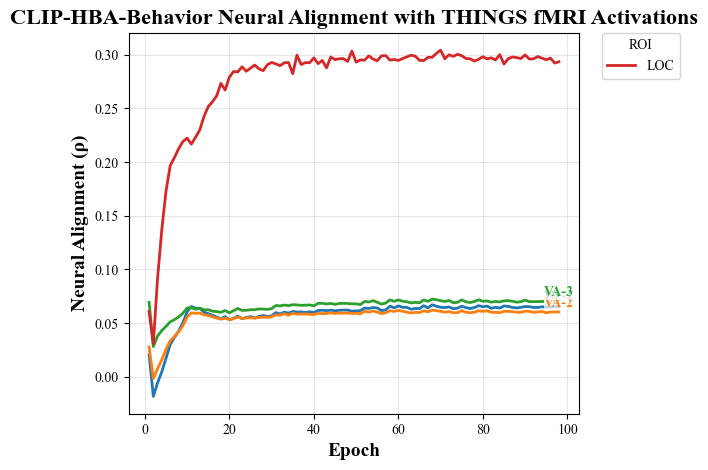

In [47]:
# Plot rho vs epoch for each ROI on the same figure with different colors
import matplotlib.pyplot as plt

# Get the actual ROI names from the DataFrame (they are lowercase: 'lLOC', 'rLOC', 'va-1', 'va-2', 'va-3')
roi_order = ['va-1', 'va-2', 'va-3', 'lLOC', 'rLOC']
roi_text_labels = {'va-1', 'va-2', 'va-3', 'lLOC', 'rLOC'}

# For ROIs not to be shown in legend, we'll collect handles and labels separately
handles = []
labels = []

label_y_offset = 0.002  # Amount to nudge label above endpoint

# Get unique ROIs from the DataFrame and sort them according to roi_order
available_rois = things_baseline_seed1_brain_rsa_results_df['roi'].unique()
# Sort ROIs according to roi_order, then add any remaining ROIs
sorted_rois = [roi for roi in roi_order if roi in available_rois] + [roi for roi in available_rois if roi not in roi_order]

for idx, roi in enumerate(sorted_rois):
    roi_df = things_baseline_seed1_brain_rsa_results_df[things_baseline_seed1_brain_rsa_results_df['roi'] == roi]
    
    if not roi_df.empty:
        # Plot the line for this ROI
        if roi in roi_text_labels:
            # Plot without label (will add text label instead)
            handle, = plt.plot(roi_df['epoch'], roi_df['rho'], linestyle='-', linewidth=2)
        else:
            # Plot with label for legend
            handle, = plt.plot(roi_df['epoch'], roi_df['rho'], linestyle='-', label=roi, linewidth=2)
            handles.append(handle)
            labels.append(roi)
        
        # Add text labels for selected ROIs
        if roi in roi_text_labels:
            x = roi_df['epoch'].iloc[-1]
            y = roi_df['rho'].iloc[-1]
            # Format ROI name for display (capitalize appropriately)
            display_name = roi.upper() if roi.startswith('va-') else roi
            y_pos = y + label_y_offset
            plt.text(
                x,                     # at the last point's epoch
                y_pos,                 # nudge upward for clarity
                display_name,
                color=handle.get_color(),
                va='bottom',           # position label above the marker
                ha='center',
                fontsize=10,
                fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='none', pad=0.2, alpha=0.7)
            )

plt.xlabel('Epoch', fontweight='bold', fontsize=14)
plt.ylabel('Neural Alignment (ρ)', fontweight='bold', fontsize=14)
plt.title('CLIP-HBA-Behavior Neural Alignment with THINGS fMRI Activations', fontweight='bold', fontsize=16)
plt.grid(True, alpha=0.3)
if handles and labels:
    plt.legend(handles, labels, title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

### Baseline Seed 2

Load the CLIP-HBA-behavior last-layer embeddings from the 720 images that make up the 720 concepts (1 images per concept).


In [48]:
things_baseline_seed2_embeddings_path = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed2/inference_results/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts')

# get all the files in the nod_baseline_embeddings_path that start with 'things_720_concepts'
things_baseline_seed2_embeddings_files = list(things_baseline_seed2_embeddings_path.glob('720_concept_embeddings*.csv'))

print(things_baseline_seed2_embeddings_files)


[PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed2/inference_results/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts/720_concept_embeddings_69.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed2/inference_results/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts/720_concept_embeddings_15.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed2/inference_results/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts/720_concept_embeddings_12.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed2/inference_resul

In [49]:
# load the last-layer embeddings from each epoch in the things_baseline_seed2_embeddings_files
things_baseline_seed2_embeddings = {}

# sort the things_baseline_seed2_embeddings_files by the epoch number
things_baseline_seed2_embeddings_files = sorted(
    things_baseline_seed2_embeddings_files, 
    key=lambda x: int(re.search(r'_(\d+)$', x.stem).group(1))
)

for file in things_baseline_seed2_embeddings_files:
    # extract the epoch number from the file name
    epoch_number = int(re.search(r'_(\d+)$', file.stem).group(1))
    print(f"Processing epoch {epoch_number}")
    
    # load the embeddings from the file
    embeddings_df = pd.read_csv(file)
    
    # add the embeddings to the baseline_hba_last_layer_embeddings_original dictionary
    things_baseline_seed2_embeddings[epoch_number] = embeddings_df


Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing epoch 50
Processin

In [50]:
# Check to make sure that the last layer embeddings take the shape (720, 68) for each epoch in the baseline_hba_last_layer_embeddings dictionary
for epoch_number in things_baseline_seed2_embeddings:
    if things_baseline_seed2_embeddings[epoch_number].shape != (720, 68):
        print(f"Epoch {epoch_number} has the wrong shape")

print(things_baseline_seed2_embeddings[1].shape)


(720, 68)


In [51]:
things_baseline_seed2_category_rdms_dict = {}
things_baseline_seed2_rdm_matrix = {}

for epoch_number in things_baseline_seed2_embeddings:

    # Initialize the dictionary for this perturbation run
    things_baseline_seed2_category_rdms_dict[epoch_number] = {}

    things_baseline_seed2_rdm_matrix[epoch_number] = {}

    # take only the numeric columns of the dataframe
    things_baseline_seed2_category_embeddings = things_baseline_seed2_embeddings[epoch_number].select_dtypes(include=[np.number]).to_numpy()
    print(things_baseline_seed2_category_embeddings.shape)

    # create a concept RDM from the concept embeddings and add it to a dictionary
    category_rdm = 1 - cosine_similarity(things_baseline_seed2_category_embeddings)
    things_baseline_seed2_rdm_matrix[epoch_number] = category_rdm
    np.fill_diagonal(category_rdm, 0)
    print(category_rdm.shape)
    upper_tri_indices = np.triu_indices_from(category_rdm, k=1)
    things_baseline_seed2_category_rdms_dict[epoch_number] = category_rdm[upper_tri_indices]


(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(72

Perform RSA between the neural RDMs and the model's last-layer RDMs during baseline training (98 epochs).


In [52]:
# Create a list to hold results
things_baseline_seed2_brain_rsa_results = []

for epoch_number in things_baseline_seed2_category_rdms_dict:
    print(f'Processing Epoch: {epoch_number}')
    model_rdm = things_baseline_seed2_category_rdms_dict[epoch_number]
    for roi in roi_average_upper_triangles:
        print(f'Processing ROI: {roi}')
        brain_rdm = roi_average_upper_triangles[roi]
        rho, p_value = stats.spearmanr(brain_rdm, model_rdm)
        print(f"ROI: {roi}, Epoch: {epoch_number}, Rho: {rho}, P-value: {p_value}")
        # Save the results to the list as a dictionary
        things_baseline_seed2_brain_rsa_results.append({
            "epoch": epoch_number,
            "roi": roi,
            "rho": rho,
            "p_value": p_value
        })

# Convert the list of results to a DataFrame
things_baseline_seed2_brain_rsa_results_df = pd.DataFrame(things_baseline_seed2_brain_rsa_results)


Processing Epoch: 1
Processing ROI: va-1
ROI: va-1, Epoch: 1, Rho: 0.01931010672053998, P-value: 8.775170018689921e-23
Processing ROI: va-2
ROI: va-2, Epoch: 1, Rho: 0.02435181454276051, P-value: 2.9206578693624505e-35
Processing ROI: va-3
ROI: va-3, Epoch: 1, Rho: 0.06808021345390322, P-value: 1.7643743735022653e-263
Processing ROI: LOC
ROI: LOC, Epoch: 1, Rho: 0.060485868029395276, P-value: 2.537949726863502e-208
Processing Epoch: 2
Processing ROI: va-1
ROI: va-1, Epoch: 2, Rho: -0.028637051716497698, P-value: 4.208654715107918e-48
Processing ROI: va-2
ROI: va-2, Epoch: 2, Rho: -0.012677122029501883, P-value: 1.1193782296689267e-10
Processing ROI: va-3
ROI: va-3, Epoch: 2, Rho: 0.019905520911978374, P-value: 4.144109379392399e-24
Processing ROI: LOC
ROI: LOC, Epoch: 2, Rho: 0.013862242278169758, P-value: 1.7522223564591056e-12
Processing Epoch: 3
Processing ROI: va-1
ROI: va-1, Epoch: 3, Rho: -0.012796657587785467, P-value: 7.47995817001293e-11
Processing ROI: va-2
ROI: va-2, Epoch: 

In [53]:
print(things_baseline_seed2_brain_rsa_results_df)


     epoch   roi       rho        p_value
0        1  va-1  0.019310   8.775170e-23
1        1  va-2  0.024352   2.920658e-35
2        1  va-3  0.068080  1.764374e-263
3        1   LOC  0.060486  2.537950e-208
4        2  va-1 -0.028637   4.208655e-48
..     ...   ...       ...            ...
363     91   LOC  0.287314   0.000000e+00
364     92  va-1  0.065066  8.433217e-241
365     92  va-2  0.058415  2.032640e-194
366     92  va-3  0.068649  7.073506e-268
367     92   LOC  0.286915   0.000000e+00

[368 rows x 4 columns]


In [54]:
# save the results_df to a csv file
things_baseline_seed2_brain_rsa_results_df.to_csv('things_baseline_seed2_brain_rsa_results.csv', index=False)


In [55]:
# load baseline_brain_rsa_results.csv
things_baseline_seed2_brain_rsa_results_df = pd.read_csv('things_baseline_seed2_brain_rsa_results.csv')


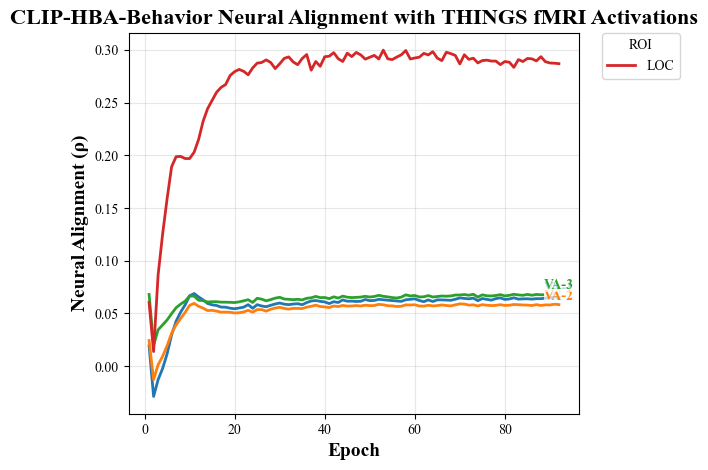

In [56]:
# Plot rho vs epoch for each ROI on the same figure with different colors
import matplotlib.pyplot as plt

# Get the actual ROI names from the DataFrame (they are lowercase: 'lLOC', 'rLOC', 'va-1', 'va-2', 'va-3')
roi_order = ['va-1', 'va-2', 'va-3', 'lLOC', 'rLOC']
roi_text_labels = {'va-1', 'va-2', 'va-3', 'lLOC', 'rLOC'}

# For ROIs not to be shown in legend, we'll collect handles and labels separately
handles = []
labels = []

label_y_offset = 0.002  # Amount to nudge label above endpoint

# Get unique ROIs from the DataFrame and sort them according to roi_order
available_rois = things_baseline_seed2_brain_rsa_results_df['roi'].unique()
# Sort ROIs according to roi_order, then add any remaining ROIs
sorted_rois = [roi for roi in roi_order if roi in available_rois] + [roi for roi in available_rois if roi not in roi_order]

for idx, roi in enumerate(sorted_rois):
    roi_df = things_baseline_seed2_brain_rsa_results_df[things_baseline_seed2_brain_rsa_results_df['roi'] == roi]
    
    if not roi_df.empty:
        # Plot the line for this ROI
        if roi in roi_text_labels:
            # Plot without label (will add text label instead)
            handle, = plt.plot(roi_df['epoch'], roi_df['rho'], linestyle='-', linewidth=2)
        else:
            # Plot with label for legend
            handle, = plt.plot(roi_df['epoch'], roi_df['rho'], linestyle='-', label=roi, linewidth=2)
            handles.append(handle)
            labels.append(roi)
        
        # Add text labels for selected ROIs
        if roi in roi_text_labels:
            x = roi_df['epoch'].iloc[-1]
            y = roi_df['rho'].iloc[-1]
            # Format ROI name for display (capitalize appropriately)
            display_name = roi.upper() if roi.startswith('va-') else roi
            y_pos = y + label_y_offset
            plt.text(
                x,                     # at the last point's epoch
                y_pos,                 # nudge upward for clarity
                display_name,
                color=handle.get_color(),
                va='bottom',           # position label above the marker
                ha='center',
                fontsize=10,
                fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='none', pad=0.2, alpha=0.7)
            )

plt.xlabel('Epoch', fontweight='bold', fontsize=14)
plt.ylabel('Neural Alignment (ρ)', fontweight='bold', fontsize=14)
plt.title('CLIP-HBA-Behavior Neural Alignment with THINGS fMRI Activations', fontweight='bold', fontsize=16)
plt.grid(True, alpha=0.3)
if handles and labels:
    plt.legend(handles, labels, title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


### Baseline Seed 3

Load the CLIP-HBA-behavior last-layer embeddings from the 720 images that make up the 720 concepts (1 images per concept).


In [57]:
things_baseline_seed3_embeddings_path = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed3/inference_results/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts')

# get all the files in the nod_baseline_embeddings_path that start with 'things_720_concepts'
things_baseline_seed3_embeddings_files = list(things_baseline_seed3_embeddings_path.glob('720_concept_embeddings*.csv'))

print(things_baseline_seed3_embeddings_files)


[PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed3/inference_results/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts/720_concept_embeddings_17.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed3/inference_results/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts/720_concept_embeddings_103.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed3/inference_results/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts/720_concept_embeddings_10.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed3/inference_resu

In [58]:
# load the last-layer embeddings from each epoch in the things_baseline_seed3_embeddings_files
things_baseline_seed3_embeddings = {}

# sort the things_baseline_seed3_embeddings_files by the epoch number
things_baseline_seed3_embeddings_files = sorted(
    things_baseline_seed3_embeddings_files, 
    key=lambda x: int(re.search(r'_(\d+)$', x.stem).group(1))
)

for file in things_baseline_seed3_embeddings_files:
    # extract the epoch number from the file name
    epoch_number = int(re.search(r'_(\d+)$', file.stem).group(1))
    print(f"Processing epoch {epoch_number}")
    
    # load the embeddings from the file
    embeddings_df = pd.read_csv(file)
    
    # add the embeddings to the baseline_hba_last_layer_embeddings_original dictionary
    things_baseline_seed3_embeddings[epoch_number] = embeddings_df


Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing epoch 50
Processin

In [59]:
# Check to make sure that the last layer embeddings take the shape (720, 68) for each epoch in the baseline_hba_last_layer_embeddings dictionary
for epoch_number in things_baseline_seed3_embeddings:
    if things_baseline_seed3_embeddings[epoch_number].shape != (720, 68):
        print(f"Epoch {epoch_number} has the wrong shape")

print(things_baseline_seed3_embeddings[1].shape)


(720, 68)


In [60]:
things_baseline_seed3_category_rdms_dict = {}
things_baseline_seed3_rdm_matrix = {}

for epoch_number in things_baseline_seed3_embeddings:

    # Initialize the dictionary for this perturbation run
    things_baseline_seed3_category_rdms_dict[epoch_number] = {}

    things_baseline_seed3_rdm_matrix[epoch_number] = {}

    # take only the numeric columns of the dataframe
    things_baseline_seed3_category_embeddings = things_baseline_seed3_embeddings[epoch_number].select_dtypes(include=[np.number]).to_numpy()
    print(things_baseline_seed3_category_embeddings.shape)

    # create a concept RDM from the concept embeddings and add it to a dictionary
    category_rdm = 1 - cosine_similarity(things_baseline_seed3_category_embeddings)
    things_baseline_seed3_rdm_matrix[epoch_number] = category_rdm
    np.fill_diagonal(category_rdm, 0)
    print(category_rdm.shape)
    upper_tri_indices = np.triu_indices_from(category_rdm, k=1)
    things_baseline_seed3_category_rdms_dict[epoch_number] = category_rdm[upper_tri_indices]


(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(720, 720)
(720, 66)
(72

Perform RSA between the neural RDMs and the model's last-layer RDMs during baseline training (98 epochs).


In [61]:
# Create a list to hold results
things_baseline_seed3_brain_rsa_results = []

for epoch_number in things_baseline_seed3_category_rdms_dict:
    print(f'Processing Epoch: {epoch_number}')
    model_rdm = things_baseline_seed3_category_rdms_dict[epoch_number]
    for roi in roi_average_upper_triangles:
        print(f'Processing ROI: {roi}')
        brain_rdm = roi_average_upper_triangles[roi]
        rho, p_value = stats.spearmanr(brain_rdm, model_rdm)
        print(f"ROI: {roi}, Epoch: {epoch_number}, Rho: {rho}, P-value: {p_value}")
        # Save the results to the list as a dictionary
        things_baseline_seed3_brain_rsa_results.append({
            "epoch": epoch_number,
            "roi": roi,
            "rho": rho,
            "p_value": p_value
        })

# Convert the list of results to a DataFrame
things_baseline_seed3_brain_rsa_results_df = pd.DataFrame(things_baseline_seed3_brain_rsa_results)


Processing Epoch: 1
Processing ROI: va-1
ROI: va-1, Epoch: 1, Rho: 0.03743142684656423, P-value: 6.530628305428182e-81
Processing ROI: va-2
ROI: va-2, Epoch: 1, Rho: 0.037034904232772815, P-value: 3.030294614473971e-79
Processing ROI: va-3
ROI: va-3, Epoch: 1, Rho: 0.07493941608521619, P-value: 0.0
Processing ROI: LOC
ROI: LOC, Epoch: 1, Rho: 0.04898790566781735, P-value: 2.87501393305939e-137
Processing Epoch: 2
Processing ROI: va-1
ROI: va-1, Epoch: 2, Rho: 0.010616311637783747, P-value: 6.615419335414662e-08
Processing ROI: va-2
ROI: va-2, Epoch: 2, Rho: 0.01525378142914664, P-value: 8.4277766655641e-15
Processing ROI: va-3
ROI: va-3, Epoch: 2, Rho: 0.03616737537509634, P-value: 1.1637875131560294e-75
Processing ROI: LOC
ROI: LOC, Epoch: 2, Rho: -0.014266820195580896, P-value: 3.906331842754191e-13
Processing Epoch: 3
Processing ROI: va-1
ROI: va-1, Epoch: 3, Rho: 0.02006415531811109, P-value: 1.809370845992627e-24
Processing ROI: va-2
ROI: va-2, Epoch: 3, Rho: 0.02442882392915559, 

In [62]:
print(things_baseline_seed3_brain_rsa_results_df)


     epoch   roi       rho        p_value
0        1  va-1  0.037431   6.530628e-81
1        1  va-2  0.037035   3.030295e-79
2        1  va-3  0.074939   0.000000e+00
3        1   LOC  0.048988  2.875014e-137
4        2  va-1  0.010616   6.615419e-08
..     ...   ...       ...            ...
407    102   LOC  0.289355   0.000000e+00
408    103  va-1  0.061669  1.734154e-216
409    103  va-2  0.054390  8.690409e-169
410    103  va-3  0.065714  1.359389e-245
411    103   LOC  0.288748   0.000000e+00

[412 rows x 4 columns]


In [63]:
# save the results_df to a csv file
things_baseline_seed3_brain_rsa_results_df.to_csv('things_baseline_seed3_brain_rsa_results.csv', index=False)


In [64]:
# load baseline_brain_rsa_results.csv
things_baseline_seed3_brain_rsa_results_df = pd.read_csv('things_baseline_seed3_brain_rsa_results.csv')


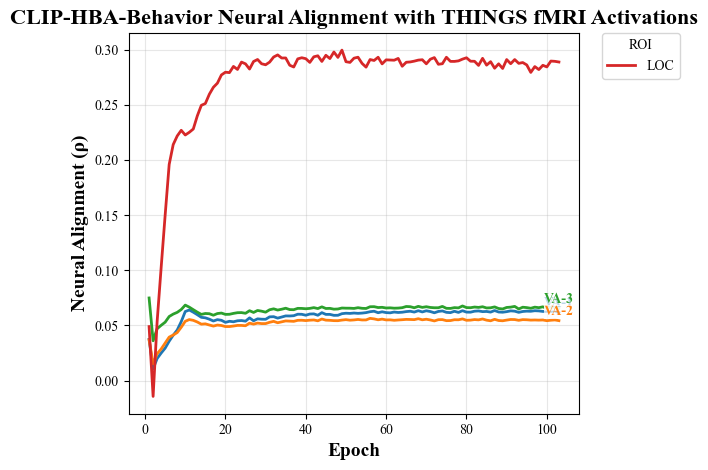

In [65]:
# Plot rho vs epoch for each ROI on the same figure with different colors
import matplotlib.pyplot as plt

# Get the actual ROI names from the DataFrame (they are lowercase: 'lLOC', 'rLOC', 'va-1', 'va-2', 'va-3')
roi_order = ['va-1', 'va-2', 'va-3', 'lLOC', 'rLOC']
roi_text_labels = {'va-1', 'va-2', 'va-3', 'lLOC', 'rLOC'}

# For ROIs not to be shown in legend, we'll collect handles and labels separately
handles = []
labels = []

label_y_offset = 0.002  # Amount to nudge label above endpoint

# Get unique ROIs from the DataFrame and sort them according to roi_order
available_rois = things_baseline_seed3_brain_rsa_results_df['roi'].unique()
# Sort ROIs according to roi_order, then add any remaining ROIs
sorted_rois = [roi for roi in roi_order if roi in available_rois] + [roi for roi in available_rois if roi not in roi_order]

for idx, roi in enumerate(sorted_rois):
    roi_df = things_baseline_seed3_brain_rsa_results_df[things_baseline_seed3_brain_rsa_results_df['roi'] == roi]
    
    if not roi_df.empty:
        # Plot the line for this ROI
        if roi in roi_text_labels:
            # Plot without label (will add text label instead)
            handle, = plt.plot(roi_df['epoch'], roi_df['rho'], linestyle='-', linewidth=2)
        else:
            # Plot with label for legend
            handle, = plt.plot(roi_df['epoch'], roi_df['rho'], linestyle='-', label=roi, linewidth=2)
            handles.append(handle)
            labels.append(roi)
        
        # Add text labels for selected ROIs
        if roi in roi_text_labels:
            x = roi_df['epoch'].iloc[-1]
            y = roi_df['rho'].iloc[-1]
            # Format ROI name for display (capitalize appropriately)
            display_name = roi.upper() if roi.startswith('va-') else roi
            y_pos = y + label_y_offset
            plt.text(
                x,                     # at the last point's epoch
                y_pos,                 # nudge upward for clarity
                display_name,
                color=handle.get_color(),
                va='bottom',           # position label above the marker
                ha='center',
                fontsize=10,
                fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='none', pad=0.2, alpha=0.7)
            )

plt.xlabel('Epoch', fontweight='bold', fontsize=14)
plt.ylabel('Neural Alignment (ρ)', fontweight='bold', fontsize=14)
plt.title('CLIP-HBA-Behavior Neural Alignment with THINGS fMRI Activations', fontweight='bold', fontsize=16)
plt.grid(True, alpha=0.3)
if handles and labels:
    plt.legend(handles, labels, title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


### Read in the single epoch perturbation sweep things embeddings

In [4]:
# Directory containing the perturbation sweep results
perturbation_seed42_dir = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42')

# List all directories in the perturbation directory
perturbation_seed42_runs = list(perturbation_seed42_dir.glob('training_run*'))

# sort the perturbation runs by the number in the folder name
perturbation_seed42_runs = sorted(
    [p for p in perturbation_seed42_runs if re.search(r'\d+$', p.stem)],
    key=lambda p: int(re.search(r'\d+$', p.stem).group())
)

print(perturbation_seed42_runs)

print(len(perturbation_seed42_runs))

[PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42/training_run1'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42/training_run2'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42/training_run3'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42/training_run4'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42/training_run5'), PosixPath('/home/wallace

In [5]:
for run in perturbation_seed42_runs:
    # check for a folder called things_720_concepts_inference_results
    if run.glob('things_720_concepts_inference_results'):
        print(run)
        # print the number of files in the things_720_concepts_inference_results folder
        print(f"Number of files in run {run.stem} things_720_concepts_inference_results: {len(list(run.glob('things_720_concepts_inference_results/*')))}") 
    else:
        print(f"No things_720_concepts_inference_results found in {run}")

/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42/training_run1
Number of files in run training_run1 things_720_concepts_inference_results: 1
/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42/training_run2
Number of files in run training_run2 things_720_concepts_inference_results: 1
/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42/training_run3
Number of files in run training_run3 things_720_concepts_inference_results: 1
/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42/training_run4
Number of files in run training_run4 thing

In [21]:
# nod_embeddings_epochXX.csv

perturbation_seed42_embeddings_original = {}

for run_path in perturbation_seed42_runs:
    # Extract training run number
    run_match = re.search(r'\d+$', run_path.stem)
    perturbation_run_number = int(run_match.group())
    print(f"Perturbation run number: {perturbation_run_number}")

    # Check for things_720_concepts_inference_results folder
    things_folder = run_path / 'things_720_concepts_inference_results' / 'things_720_concepts_inference_results_720_concepts'
    print(f"Found THINGS results folder in perturbation run {perturbation_run_number}")
    if not things_folder.exists():
        print(f"No things_720_concepts_inference_results found in {run_path}")
        continue

    # Get all CSV files in the things_720_concepts_inference_results folder
    csv_files = list(things_folder.glob('720_concept_embeddings*.csv'))
    print(f"Found CSV files for {len(csv_files)} epochs in {things_folder}")

    # Initialize dictionary for this training run
    perturbation_seed42_embeddings_original[perturbation_run_number] = {}

    # Filter files that match the pattern and extract epoch numbers
    valid_csv_files = []
    for csv_file in csv_files:
        # Match digits at the end of the filename (stem doesn't include .csv extension)
        epoch_match = re.search(r'(\d+)$', csv_file.stem)
        if epoch_match:
            epoch_number = int(epoch_match.group(1))
            valid_csv_files.append((epoch_number, csv_file))
        else:
            print(f"Warning: Skipping file {csv_file.name} - does not match expected pattern")
    
    # Sort by epoch number
    valid_csv_files = sorted(valid_csv_files, key=lambda x: x[0])

    # Read in the CSV files
    for epoch_number, csv_file in valid_csv_files:
        print(f"Processing epoch {epoch_number}")
        
        # Load the CSV file (contains image embeddings)
        embeddings_df = pd.read_csv(csv_file)
        perturbation_seed42_embeddings_original[perturbation_run_number][epoch_number] = embeddings_df



Perturbation run number: 1
Found THINGS results folder in perturbation run 1
Found CSV files for 1 epochs in /home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42/training_run1/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts
Processing epoch 1
Perturbation run number: 2
Found THINGS results folder in perturbation run 2
Found CSV files for 1 epochs in /home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42/training_run2/things_720_concepts_inference_results/things_720_concepts_inference_results_720_concepts
Processing epoch 2
Perturbation run number: 3
Found THINGS results folder in perturbation run 3
Found CSV files for 1 epochs in /home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/sin

In [22]:
# Check the columns of the first dataframe
first_run = list(perturbation_seed42_embeddings_original.keys())[0]
first_epoch = list(perturbation_seed42_embeddings_original[first_run].keys())[0]
df = perturbation_seed42_embeddings_original[first_run][first_epoch]

print(f"Columns: {list(df.columns)}")
print(f"Shape: {df.shape}")
print(df.head())

Columns: ['image', 'concept', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65']
Shape: (720, 68)
                      image           concept          0          1  \
0             acorn_12s.jpg             acorn   8.985238  12.214366   
1            airbag_12s.jpg            airbag  10.565228  11.257096   
2  aircraft_carrier_12s.jpg  aircraft_carrier  10.976088   8.485510   
3          airplane_12n.jpg          airplane  12.407321   8.379347   
4         alligator_12s.jpg         alligator   8.803510  10.520331   

           2          3          4          5          6          7  ...  \
0  12.498762  11.862042  15.175332  12.211792  13.189675  12.609

In [24]:
# create a dictionary to store the last-layer model RDMs for each epoch for each training run

perturbation_seed42_category_rdms_dict = {}

for perturbation_run_number in perturbation_seed42_embeddings_original:

    # Initialize the dictionary for this perturbation run
    perturbation_seed42_category_rdms_dict[perturbation_run_number] = {}

    for epoch_number in perturbation_seed42_embeddings_original[perturbation_run_number]:
        print(f"Perturbation run number: {perturbation_run_number}, Epoch number: {epoch_number}")

        # take only the numeric columns of the dataframe (exclude string columns like image names)
        df = perturbation_seed42_embeddings_original[perturbation_run_number][epoch_number]
        perturbation_seed42_category_embeddings = df.select_dtypes(include=[np.number]).to_numpy()
        print(perturbation_seed42_category_embeddings.shape)

        # create a concept RDM from the concept embeddings and add it to a dictionary
        category_rdm = 1 - cosine_similarity(perturbation_seed42_category_embeddings)
        np.fill_diagonal(category_rdm, 0)
        print(category_rdm.shape)
        upper_tri_indices = np.triu_indices_from(category_rdm, k=1)
        perturbation_seed42_category_rdms_dict[perturbation_run_number][epoch_number] = category_rdm[upper_tri_indices]

Perturbation run number: 1, Epoch number: 1
(720, 66)
(720, 720)
Perturbation run number: 2, Epoch number: 2
(720, 66)
(720, 720)
Perturbation run number: 3, Epoch number: 3
(720, 66)
(720, 720)
Perturbation run number: 4, Epoch number: 4
(720, 66)
(720, 720)
Perturbation run number: 5, Epoch number: 5
(720, 66)
(720, 720)
Perturbation run number: 6, Epoch number: 6
(720, 66)
(720, 720)
Perturbation run number: 7, Epoch number: 7
(720, 66)
(720, 720)
Perturbation run number: 8, Epoch number: 8
(720, 66)
(720, 720)
Perturbation run number: 9, Epoch number: 9
(720, 66)
(720, 720)
Perturbation run number: 10, Epoch number: 10
(720, 66)
(720, 720)
Perturbation run number: 11, Epoch number: 11
(720, 66)
(720, 720)
Perturbation run number: 12, Epoch number: 12
(720, 66)
(720, 720)
Perturbation run number: 13, Epoch number: 13
(720, 66)
(720, 720)
Perturbation run number: 14, Epoch number: 14
(720, 66)
(720, 720)
Perturbation run number: 15, Epoch number: 15
(720, 66)
(720, 720)
Perturbation 

In [31]:
# Create a list to hold results
things_perturbation_seed42_brain_rsa_results = []

# perturbation_seed42_category_rdms_dict has nested structure: [perturbation_run_number][epoch_number]
for perturbation_run_number in perturbation_seed42_category_rdms_dict:
    for epoch_number in perturbation_seed42_category_rdms_dict[perturbation_run_number]:
        print(f'Processing Perturbation Run: {perturbation_run_number}, Epoch: {epoch_number}')
        model_rdm = perturbation_seed42_category_rdms_dict[perturbation_run_number][epoch_number]
        for roi in roi_average_upper_triangles:
            print(f'Processing ROI: {roi}')
            brain_rdm = roi_average_upper_triangles[roi]
            rho, p_value = stats.spearmanr(brain_rdm, model_rdm)
            print(f"Perturbation Run: {perturbation_run_number}, ROI: {roi}, Epoch: {epoch_number}, Rho: {rho}, P-value: {p_value}")
            # Save the results to the list as a dictionary
            things_perturbation_seed42_brain_rsa_results.append({
                "perturbation_run": perturbation_run_number,
                "epoch": epoch_number,
                "roi": roi,
                "rho": rho,
                "p_value": p_value
            })

# Convert the list of results to a DataFrame
things_perturbation_seed42_brain_rsa_results_df = pd.DataFrame(things_perturbation_seed42_brain_rsa_results)

Processing Perturbation Run: 1, Epoch: 1
Processing ROI: va-1
Perturbation Run: 1, ROI: va-1, Epoch: 1, Rho: 0.03224312811415601, P-value: 1.6680039624849051e-60
Processing ROI: va-2
Perturbation Run: 1, ROI: va-2, Epoch: 1, Rho: 0.03675017268216444, P-value: 4.647879670162912e-78
Processing ROI: va-3
Perturbation Run: 1, ROI: va-3, Epoch: 1, Rho: 0.07109262871298146, P-value: 3.5396351678912206e-287
Processing ROI: LOC
Perturbation Run: 1, ROI: LOC, Epoch: 1, Rho: 0.04081313872647034, P-value: 7.631505228527138e-96
Processing Perturbation Run: 2, Epoch: 2
Processing ROI: va-1
Perturbation Run: 2, ROI: va-1, Epoch: 2, Rho: -0.014010172306743921, P-value: 1.01707994986766e-12
Processing ROI: va-2
Perturbation Run: 2, ROI: va-2, Epoch: 2, Rho: 0.0029078786854192613, P-value: 0.13902872142273773
Processing ROI: va-3
Perturbation Run: 2, ROI: va-3, Epoch: 2, Rho: 0.04047072858491739, P-value: 2.839150163940565e-94
Processing ROI: LOC
Perturbation Run: 2, ROI: LOC, Epoch: 2, Rho: 0.02243570

In [32]:
# save the neural_rsa_perturb_sweep_df dataframe to a csv file
things_perturbation_seed42_brain_rsa_results_df.to_csv('things_perturbation_seed42_brain_rsa_results.csv', index=False)